In [1]:
import numpy as np
import time,os
from io import StringIO
np.set_printoptions(linewidth=160)
from lib.ktn_io import *
from lib.gt_tools import *
from scipy.sparse import save_npz,load_npz, diags, eye
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:

data_path = "KTN_data/LJ38/4k"

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

Nmax=8000

Aind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.A')):
    Aind = np.append(Aind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Aind = Aind[2:]

Bind = np.zeros(1).astype(int)
for line in open(os.path.join(data_path,'min.B')):
    Bind = np.append(Bind,np.genfromtxt(StringIO(line.strip())).astype(int)-1)
Bind = Bind[2:]


# Load Data, define regions, calculate $\langle\tau^{1,2}\rangle$

In [17]:

betar =np.linspace(0.01,1./0.15,30)#arange(1,9)
tau = np.zeros((betar.size,8))
#pbar = tqdm(total = (betar.size),mininterval=0.0,leave=False)
for i in range(betar.size):
    
    B, K, D, N, u, s, Emin, sel = load_mat(path=data_path,beta=betar[i],Emax=None,Nmax=None)#,screen=(i==0))
    #beta, B, K, D, N, u, s, kt, kcon, Emin, sel = load_save_mat(path=data_path,beta=betar[i],Emax=None,Nmax=None,generate=generate)
    D = np.ravel(K.sum(axis=0))
        
    keep = np.zeros(sel.size,bool)
    keep[Bind] = True
    B_states = keep[sel]
    
    keep = np.zeros(sel.size,bool)
    keep[Aind] = True
    A_states = keep[sel]
    
    BF = betar[i]*u-s
    
    
    rho = np.exp(-BF) 
    rho_A = rho.copy()
    rho_B = rho.copy()
    rho_A[~A_states] = 0.0
    rho_B[~B_states] = 0.0
    rho_A = rho_A[~B_states]
    rho_B = rho_B[~A_states]
    rho_A /= rho_A.sum()
    rho_B /= rho_B.sum()
    rho = [rho_A,rho_B]
    sel = [~B_states,~A_states]
    
    
    inter_region = ~(B_states + A_states)
    rB, rD, full_rK, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=50,retK=True,Ndense=50)
    r_A_states = A_states[~inter_region]
    r_B_states = B_states[~inter_region]
    r_BF = BF[~inter_region]
    
    r_rho = np.exp(-r_BF) 
    r_rho_A = r_rho.copy()
    r_rho_B = r_rho.copy()
    r_rho_A[~r_A_states] = 0.0
    r_rho_B[~r_B_states] = 0.0
    r_rho_A = r_rho_A[~r_B_states]
    r_rho_B = r_rho_B[~r_A_states]
    r_rho_A /= r_rho_A.sum()
    r_rho_B /= r_rho_B.sum()
    r_rho = [r_rho_A,r_rho_B]
    r_sel = [~r_B_states,~r_A_states]
    
    
    
    for j in range(2):
        Q = (diags(D[sel[j]])-K[sel[j],:][:,sel[j]])
        x = spsolve(Q,rho[j])
        y = spsolve(Q,x)
        
        tau[i][2*j+0] = x.sum()
        tau[i][2*j+1] = np.sqrt(2.0*y.sum()-tau[i][2*j]**2)
        x = spsolve(full_rK[r_sel[j],:][:,r_sel[j]],r_rho[j])
        y = spsolve(full_rK[r_sel[j],:][:,r_sel[j]],x)
        
        tau[i][4+2*j+0] = x.sum()
        tau[i][4+2*j+1] = np.sqrt(2.0*y.sum()-tau[i][4+2*j]**2)
#    pbar.update(1)
#pbar.close()
        
    



/home/tomswinburne/miniconda2/lib/python3.7/site-packages/scikits/umfpack/umfpack.py:729: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.77e+12)
  warnings.warn(msg, UmfpackWarning)


# Plot

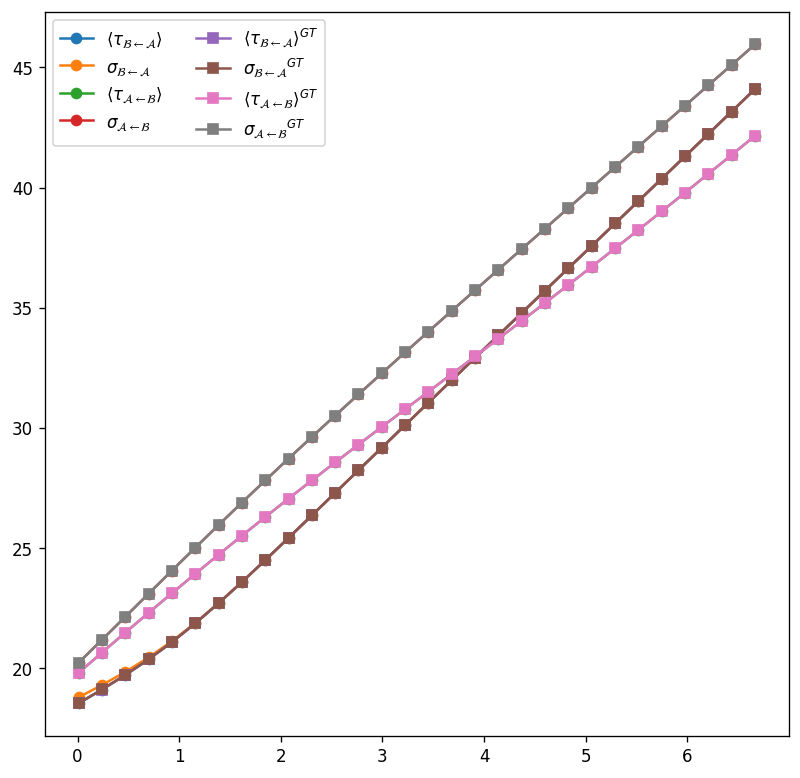

In [18]:
#"\sqrt{\langle\tau^2_{\mathcal{B\leftarrow A}}\rangle-\langle\tau_{\mathcal{B\leftarrow A}}\rangle^2}$",\
fig,axs = plt.subplots(1,1,figsize=(8,8),dpi=120,sharey=True)
labs = [r"$\langle\tau_{\mathcal{B\leftarrow A}}\rangle$",
        r"$\sigma_{\mathcal{B\leftarrow A}}$",\
        r"$\langle\tau_{\mathcal{A\leftarrow B}}\rangle$",\
        r"$\sigma_{\mathcal{A\leftarrow B}}$"]
for k in range(4):
    axs.plot(betar,np.log(tau[:,k]),'o-',label=labs[k])
for k in range(4):
    axs.plot(betar,np.log(tau[:,4+k]),'s-',label=labs[k]+r"$^{GT}$")

axs.legend(ncol=2)


/home/tomswinburne/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/tomswinburne/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


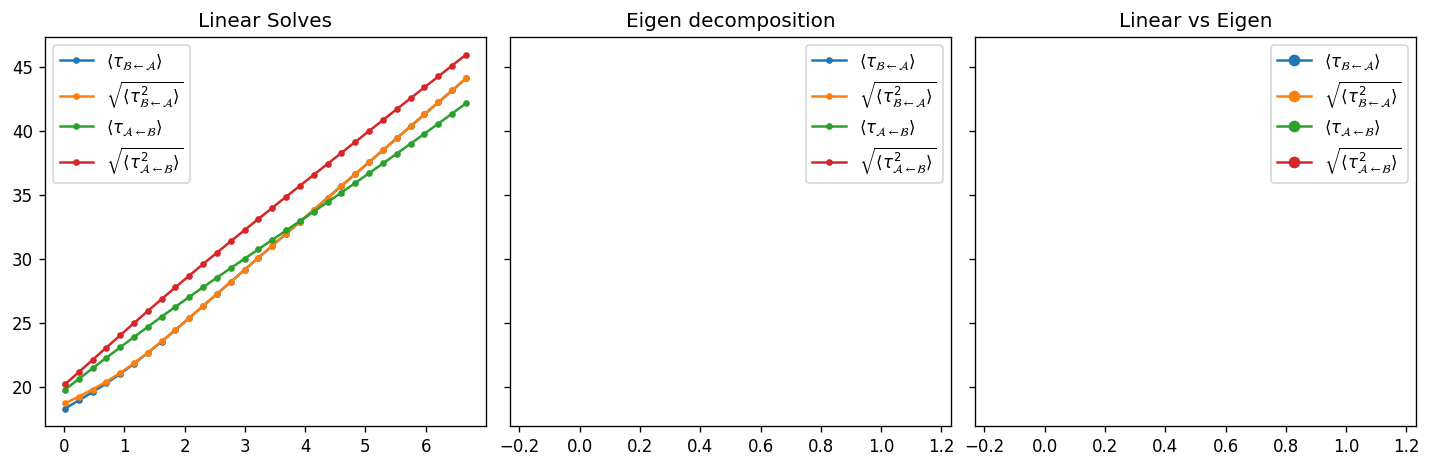

In [6]:
fig,axs = plt.subplots(1,3,figsize=(12,4),dpi=120,sharey=True)
labs = [r"$\langle\tau_{\mathcal{B\leftarrow A}}\rangle$",r"$\sqrt{\langle\tau^2_{\mathcal{B\leftarrow A}}\rangle}$",r"$\langle\tau_{\mathcal{A\leftarrow B}}\rangle$",r"$\sqrt{\langle\tau^2_{\mathcal{A\leftarrow B}}\rangle}$"]
for j in range(2):
    for k in range(4):
        axs[j].plot(betar,np.log(tau[:,4*j+k]),'.-',label=labs[k])
for k in range(4):
    axs[2].plot(np.log(tau[:,4*0+k]),np.log(tau[:,4*1+k]),'o-',label=labs[k])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title("Linear Solves")
axs[1].set_title("Eigen decomposition")
axs[2].set_title("Linear vs Eigen")
plt.tight_layout()

In [ ]:
_beta = 0.05

beta, B, K, D, N, u, s, kt, kcon, Emin, sel = load_save_mat(path=data_path,beta=_beta,Emax=None,Nmax=Nmax,generate=generate)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

keep = np.zeros(sel.size,bool)
keep[Bind] = True
B_states = keep[sel]

keep = np.zeros(sel.size,bool)
keep[Aind] = True
A_states = keep[sel]

Q = (np.diag(D)-K.todense())[~B_states,:][:,~B_states]
print(beta)
rho = np.exp(-BF)
rho[~A_states] = 0.0
rho = rho[~B_states]
rho /= rho.sum()

nu,v,w = spla.eig(Q,left=True,right=True)

eQ = np.zeros(Q.shape)
nu = nu.real
v = v.real
w = w.real

for i in range(nu.size):
    eQ += nu[i]*np.outer(w[:,i],v[:,i])/np.dot(w[:,i],v[:,i])


t = np.exp(np.linspace(np.log(.00001),np.log(.6),1000))
tau = 0.0
p = np.zeros(t.size)
print(v.shape,w.shape,nu.shape)
for i in range(nu.size):
    #print(nu[i])
    www = w[:,i].sum() * (v[:,i]*rho).sum() / np.dot(w[:,i],v[:,i])

    p += www * nu[i] * np.exp(-nu[i]*t)
    
    tau += www / nu[i]

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=120)

axs[0].plot(t,p,'-')
axs[0].plot(t,np.exp(-t/tau)/tau,'-')

axs[1].plot(rho)
axs[1].plot(w[:,nu.argmin()]/w[:,nu.argmin()].sum())

axs[0].set_xscale("log")
axs[0].set_yscale("log")
    

# Graph transformation to remove intermediate states

In [ ]:
trmb = 50 # block size


# NB "full_rK" is in fact equal to D-K=(1-B).D in earlier notation - this is done 

rB, rD, full_rK, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=trmb,retK=True,Ndense=50)


r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]
r_BF = BF[~inter_region]

oneA = np.ones(r_A_states.sum())
oneB = np.ones(r_B_states.sum())
r_BF = BF[~inter_region]
rDSS = D[~inter_region]





# Eigendecomposition of GT matrix and evaluation of $k^{QSD}, k^{SS}, k^{NSS}$

## We also perform same eigendecomposition following additional GT to group all target states

## This is analytically identical, but in practice is numerically beneficial

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=160)

kdata = [] # SS,NSS,QSD,nu

for i, r_s in enumerate([r_A_states,r_B_states]) :
        
    l, v = spla.eig(full_rK[r_s,:][:,r_s].todense())
    
    qsdo = np.abs(l.real).argsort()
    nu = l.real[qsdo]
    
    
    
    
    
    rho = np.exp(-r_BF[r_s])
    rho /= rho.sum()
    
    qsd = v[:,qsdo[0]]
    qsd /= qsd.sum()
    
    
    
    
    
    """
       Further GT compression of final states - differences are due to numerical issues
    """    
    rm_reg = np.zeros(rN,bool)   
    rm_reg[(~r_s).nonzero()[0]] = True
    rm_reg[(~r_s).nonzero()[0][r_BF[~r_s].argmin()]] = False
    
    rrB, rrD, full_rrK, rrN, retry = gt_seq(N=rN,rm_reg=rm_reg,B=rB,D=rD,trmb=1,retK=True,Ndense=1)
    rr_s = r_s[~rm_reg]
    
    rl, rv = spla.eig(full_rrK[rr_s,:][:,rr_s].todense())
    
    rqsdo = np.abs(rl.real).argsort()
    rnu = rl.real[rqsdo]
    
    qsd = rv[:,rqsdo[0]]
    qsd /= qsd.sum()
    
    C = np.ravel(rrB[~rr_s,:][:,rr_s].sum(axis=0))
    
    
    irrK = spla.inv(full_rrK[rr_s,:][:,rr_s].todense())
    tau = irrK.dot(rho).sum(axis=0)
    T_AB = irrK.sum(axis=0)
    k_F = (rho/T_AB).sum()
    
    """
        SS, NSS, QSD, nu, 1.K.qsd, kF, 1/tau
    """
    kSS = C.dot(np.diag(rDSS[r_s])).dot(rho)
    
    kNSS = C.dot(np.diag(rrD[rr_s])).dot(rho)
    
    kQSD = C.dot(np.diag(rrD[rr_s])).dot(qsd)
    
    oneKqsd = 0.0#(rrK[rr_s,:][:,rr_s].dot(qsd)).sum()
    
    kdata.append([kSS,kNSS,kQSD,rnu[0],oneKqsd,k_F,1.0/tau,qsd,rho])
    
    

       
    
    ax[i].set_title(r"Spectrum for %s$\to$%s, $\nu_1/\nu_0$=%4.4g" % (names[i],names[1-i],rnu[1]/rnu[0]))
    ax[i].set_ylabel("Eigenvalues")
    ax[i].set_xlabel("Index")
    ax[i].plot(nu,'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[i].plot(rnu,'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[i].set_yscale("log")
    ax[i].legend()
plt.tight_layout()


# Check for numerical consistency

## We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

## and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}=k^{QSD}$    =   "k_qsd"

## I find ${\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ is the least reliable

## We also calculate $k^{SS}, k^{NSS}, k^F$ and $k^*=1/\langle\tau\rangle$, but these are not required to equal "kQSD"

## Results clearly show QSD for icosahedral basin is strongly non-Boltzmann ($k^{QSD}\neq k^{NSS}$)


In [ ]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=160)

for i in range(2):
    print("\n\t %s -> %s" % (names[i],names[1-i]))
    
    #     0: kSS, 1: kNSS, 2: kQSD, 3: nu, 4: 1.K.qsd, 5: k_F, 6: k* =1.0/tau
    
    print("\n\t nu_0 = %4.4g\n\n\t 1.K.qsd = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][3],kdata[i][4],(kdata[i][4]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kQSD = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][2],(kdata[i][2]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kF = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][5],(kdata[i][5]/kdata[i][3])*100.0-100.0))
    
    print("\n\t k*= %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][6],(kdata[i][6]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][0],(kdata[i][0]/kdata[i][3])*100.0-100.0))
    
    print("\n\t kNSS = %4.4g. Error to nu_0 = %4.4g%%" % \
          (kdata[i][1],(kdata[i][1]/kdata[i][3])*100.0-100.0))
    
    print("\n---QSD.max()=%4.10g, rho.max()=%4.10g ------\n\n" % (kdata[i][-2].max(),kdata[i][-1].max()))
    
        
    
    ax[0,i].set_title(r"QSD and Boltzmann for %s basin w/GT" % (names[i]))
    ax[0,i].set_ylabel("Occupation Probability")
    ax[0,i].set_xlabel("Basin State Index")
    ax[0,i].plot(kdata[i][-2],'s',label=r"QSD")
    ax[0,i].plot(kdata[i][-1],'o',label=r"Boltzmann")
    ax[0,i].set_yscale("log")
    ax[0,i].legend()
    
    ax[0,i].set_title(r"QSD vs Boltzmann for %s basin w/GT" % (names[i]))
    ax[1,i].set_xlabel("Boltzmann Occupation Probability")
    ax[1,i].set_ylabel("QSD Occupation Probability")
    ax[1,i].plot(kdata[i][-1],kdata[i][-2],'o',label=r"Boltzmann vs QSD")
    
    pc = np.linspace(min(kdata[i][-2].min(),kdata[i][-1].min()),1.0,10,endpoint=True)
    ax[1,i].plot(pc,pc,'k--',label="Boltz==QSD")
    
    ax[1,i].set_yscale("log")
    ax[1,i].set_xscale("log")
    ax[1,i].set_xlim(xmax=5.0)
    ax[1,i].set_ylim(ymax=5.0)
    
    ax[1,i].legend()
    
plt.tight_layout()